CSCI 4852 & 6952: Deep Learning (Spring 2023)  

Instructor: Alina Lazar (alazar@ysu.edu)  
GitHub repository:https://github.com/alinutzal/CSCI-xx52-Deep-Learning-
---

# AlexNet on Cifar-10

## Imports

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [3]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 200
NUM_EPOCHS = 55
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [5]:
##########################
### MNIST DATASET
##########################

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader,  test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.2,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([200, 3, 64, 64])
Image label dimensions: torch.Size([200])
Class labels of 10 examples: tensor([1, 1, 1, 7, 7, 4, 8, 8, 6, 6])


In [6]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

200
50
50


## Model

In [7]:
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

Epoch: 001/055 | Batch 0000/0200 | Loss: 2.3046
Epoch: 001/055 | Batch 0100/0200 | Loss: 2.2977
Epoch: 001/055 | Train: 15.01% 
Time elapsed: 0.43 min
Epoch: 002/055 | Batch 0000/0200 | Loss: 2.2283
Epoch: 002/055 | Batch 0100/0200 | Loss: 2.0015
Epoch: 002/055 | Train: 19.11% 
Time elapsed: 0.83 min
Epoch: 003/055 | Batch 0000/0200 | Loss: 1.9365
Epoch: 003/055 | Batch 0100/0200 | Loss: 1.9515
Epoch: 003/055 | Train: 33.59% 
Time elapsed: 1.24 min
Epoch: 004/055 | Batch 0000/0200 | Loss: 1.6746
Epoch: 004/055 | Batch 0100/0200 | Loss: 1.5584
Epoch: 004/055 | Train: 40.49% 
Time elapsed: 1.63 min
Epoch: 005/055 | Batch 0000/0200 | Loss: 1.6308
Epoch: 005/055 | Batch 0100/0200 | Loss: 1.5794
Epoch: 005/055 | Train: 44.94% 
Time elapsed: 2.04 min
Epoch: 006/055 | Batch 0000/0200 | Loss: 1.4783
Epoch: 006/055 | Batch 0100/0200 | Loss: 1.3833
Epoch: 006/055 | Train: 47.51% 
Time elapsed: 2.45 min
Epoch: 007/055 | Batch 0000/0200 | Loss: 1.4151
Epoch: 007/055 | Batch 0100/0200 | Loss: 1.375

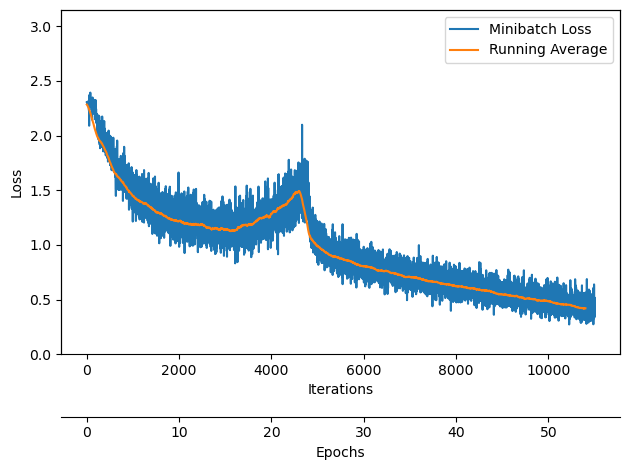

ValueError: x and y must have same first dimension, but have shapes (55,) and (0,)

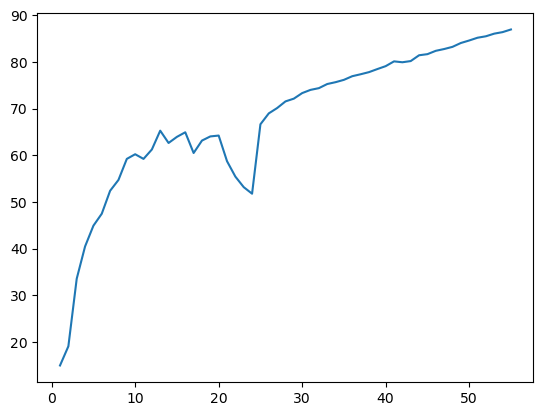

In [8]:
model = AlexNet(num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

In [ ]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()